# Apache Clipper 
## demo 5 : Face gender detection

* 性別辨識專案source from 
https://github.com/arunponnusamy/gender-detection-keras

In [1]:
import os
import io
import glob
import random
import numpy as np

from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin import ClipperException
import clipper_admin.deployers.keras as keras_deployer

import cvlib
from PIL import Image

import json
import base64
import requests
import cv2
from datetime import datetime

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array,array_to_img
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import get_file
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Sequential
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Model

## A. training smaller VGGNet

In [2]:
def build_model(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))
    return model

In [ ]:
epochs = 10
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob("gender-detection-keras/gender_dataset_face/**/*", recursive=True) if not os.path.isdir(f)] 
random.seed(42)
random.shuffle(image_files)

# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# build model
model = build_model(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
epochs=epochs, verbose=1)

In [ ]:
model.summary()

In [ ]:
model.save('my_model.model')

## B. load model 

In [3]:

model = load_model('pre-trained/gender_detection.model')

19-09-05:11:54:51 WARNING  [deprecation.py:323] From /opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
19-09-05:11:54:51 WARNING  [deprecation.py:506] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
19-09-05:11:54:52 WARNING  [deprecation.py:323] From /opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


# Initialize the Clipper cluster

In [4]:
def orange_func(model, inputs):
    def _predict_one(one_input_arr):
        try:
            image = Image.open(io.BytesIO(one_input_arr))
    ### decorator top end
            
            ### function start
            # image = Image.open(io.BytesIO(open('waue.jpg','rb').read()))
#             image = Image.open(io.BytesIO(open('peggybio.png','rb').read()))

            image = img_to_array(image)
            classes = ['man','woman']
            face, confidence = cvlib.detect_face(image)

            for idx, f in enumerate(face):

                 # get corner points of face rectangle       
                (startX, startY) = f[0], f[1]
                (endX, endY) = f[2], f[3]

                print(startX, startY, endX, endY)
                # draw rectangle over face
                cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)

                # crop the detected face region
                face_crop = np.copy(image[startY:endY,startX:endX])

                # preprocessing for gender detection model
                face_crop = cv2.resize(face_crop, (96,96))
                face_crop = face_crop.astype("float") / 255.0
                face_crop = img_to_array(face_crop)
                face_crop = np.expand_dims(face_crop, axis=0)
                conf = model.predict(face_crop)[0]
                ret_str = str(classes) + str(conf) 
#                 print(ret_str)
            ### function end
            
    ### decorator botton start
            return ret_str
        except Exception as e:
            print(e)
            return []
    
    return [_predict_one(i) for i in inputs]

In [5]:
clipper_conn = ClipperConnection(DockerContainerManager())

In [6]:
from clipper_admin import ClipperException
try:
    clipper_conn.start_clipper()
except ClipperException as e:
    clipper_conn.connect()
except Exception as e:
    print(e)

19-09-05:11:54:59 WARNING  [clipper_admin.py:141] [default-cluster] Error starting Clipper: Cluster default-cluster cannot be started because it already exists. Please use ClipperConnection.connect() to connect to it.
19-09-05:11:54:59 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [7]:
app_name = 'face-gender-orangejuice'+str(random.randint(0,1000))
# app_name = 'face-gender-orangejuice'
model_name = app_name
print(app_name)

face-gender-orangejuice637


# Deploy

* 客製化的image
https://cloud.docker.com/repository/docker/waue0920/face_detect_cv2

In [8]:

keras_deployer.create_endpoint(   clipper_conn=clipper_conn,
                                  name=model_name,
                                  input_type='bytes',
                                  func=orange_func,
                                  model_path_or_object=model,
                                  registry="waue0920",
                                  version='2',
                                  num_replicas=1,
                                  base_image="face_detect_cv2",
                                  batch_size=1,  # Disable adaptive batching policy
                                  #pkgs_to_install=['pillow','keras','cvlib','opencv-python','sklearn','numpy']
                              )

19-09-05:11:55:03 INFO     [clipper_admin.py:236] [default-cluster] Application face-gender-orangejuice637 was successfully registered
19-09-05:11:55:03 INFO     [deployer_utils.py:41] Saving function to /tmp/tmph84oioxuclipper
19-09-05:11:55:03 INFO     [deployer_utils.py:51] Serialized and supplied predict function
19-09-05:11:55:03 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmph84oioxuclipper
19-09-05:11:55:06 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM face_detect_cv2
19-09-05:11:55:06 INFO     [clipper_admin.py:539] [default-cluster]  ---> 23fc71c76f17
19-09-05:11:55:06 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmph84oioxuclipper /model/
19-09-05:11:55:06 INFO     [clipper_admin.py:539] [default-cluster]  ---> 621f121ab1bc
19-09-05:11:55:06 INFO     [clipper_admin.py:539] [default-cluster] Successfully built 621f121ab1bc
19-09-05:11:55:06 INFO     [clipper_admin.py:539] 

# Send some requests to the Clipper cluster

## test 1

In [9]:

headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name=app_name)
print(url)

http://localhost:1337/face-gender-orangejuice637/predict


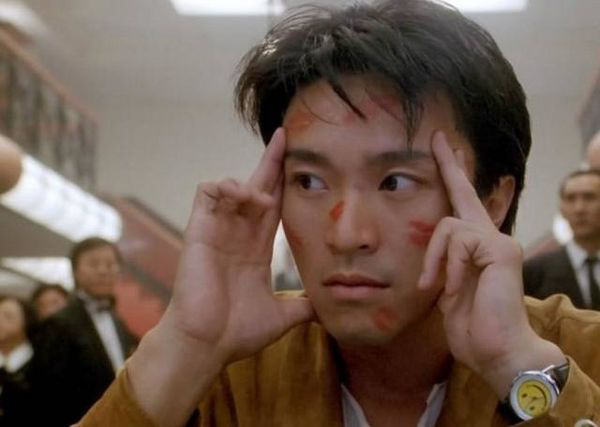

In [10]:
display(Image.open('star1.jpg'))

In [11]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('star1.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [12]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":36,"output":"['man', 'woman'][9.9913740e-01 9.0927555e-04]","default":false}', 265.017000 ms


## test2

In [13]:

headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name=app_name)
print(url)

http://localhost:1337/face-gender-orangejuice637/predict


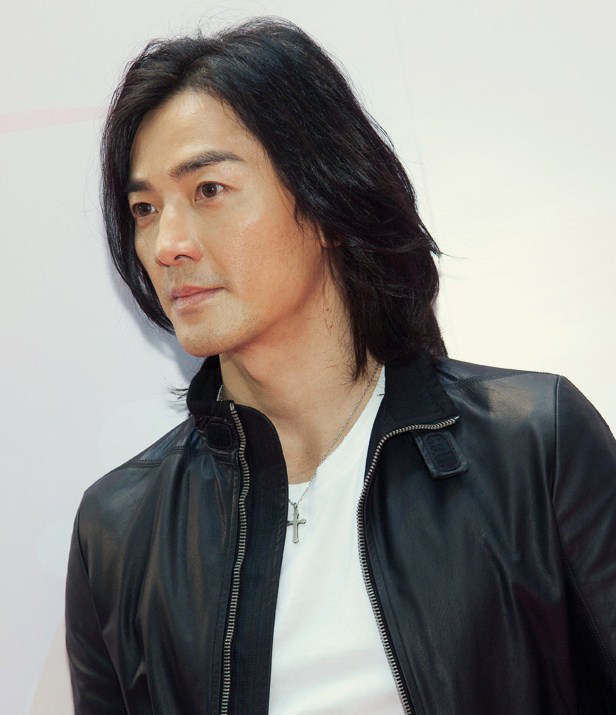

In [14]:
display(Image.open('1man2.jpg'))

In [15]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('1man2.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [16]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":37,"output":"['man', 'woman'][0.97602046 0.02527873]","default":false}', 77.159000 ms


## test3

In [13]:

headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name=app_name)
print(url)

http://localhost:1337/face-gender-orangejuice637/predict


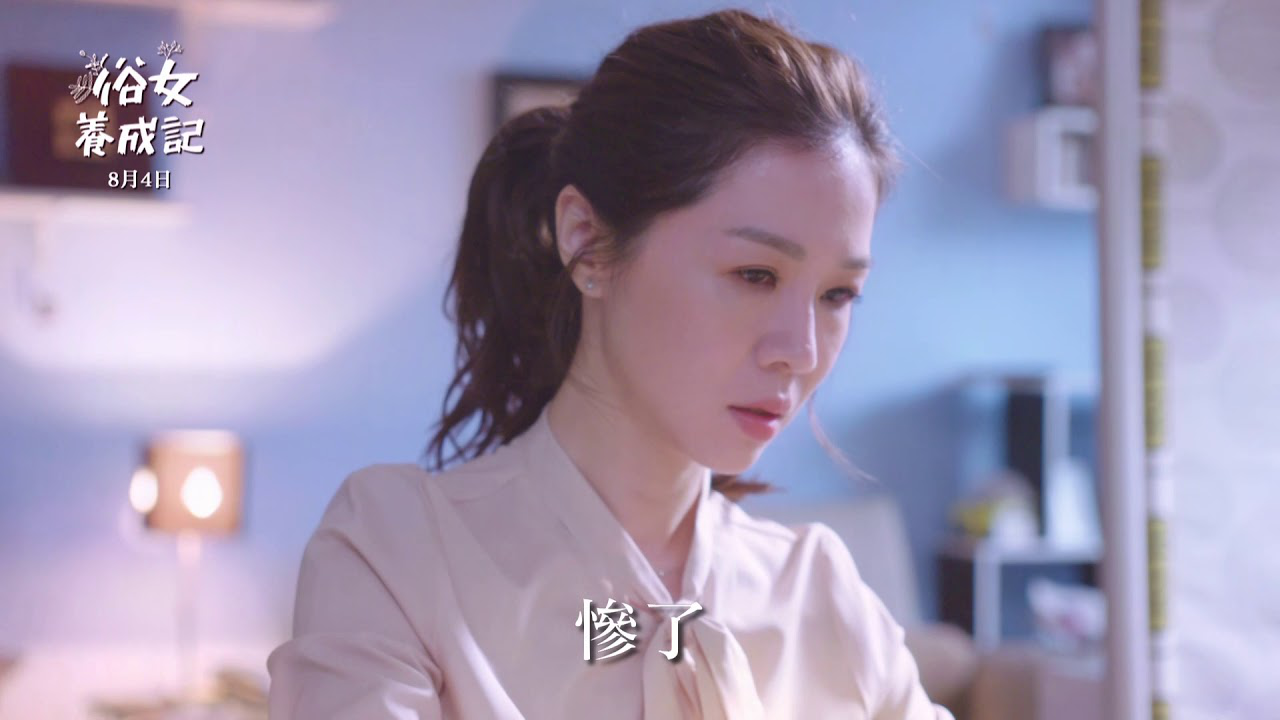

In [17]:
display(Image.open('su3.jpg'))

In [18]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('su3.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [19]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":38,"output":"['man', 'woman'][0.42509717 0.58739144]","default":false}', 80.124000 ms


# DEBUG 單元測試

## 1.先測試predict function 

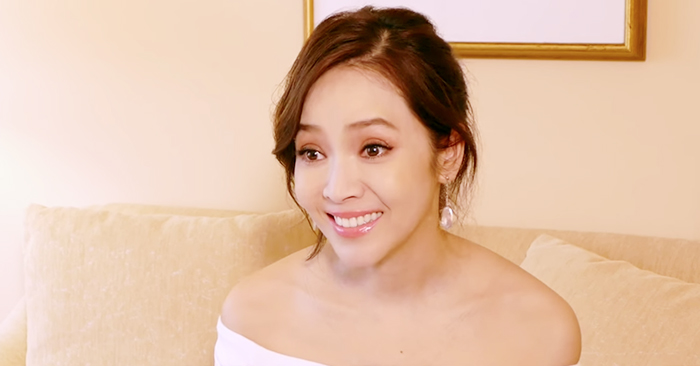

In [20]:
# this_image='star1.jpg'
# this_image='1man2.jpg'
# this_image='su3.jpg'
# this_image='dlin4.jpg'
this_image='pt5.jpg'
# this_image='pretty6.jpg'

display(Image.open(this_image))
# image = Image.open(io.BytesIO(open('waue.jpg','rb').read()))
image = Image.open(io.BytesIO(open(this_image,'rb').read()))

In [21]:
image = img_to_array(image)
classes = ['man','woman']
face, confidence = cvlib.detect_face(image)

for idx, f in enumerate(face):

     # get corner points of face rectangle       
    (startX, startY) = f[0], f[1]
    (endX, endY) = f[2], f[3]

    print(startX, startY, endX, endY)
    # draw rectangle over face
    cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)

    # crop the detected face region
    face_crop = np.copy(image[startY:endY,startX:endX])

    # preprocessing for gender detection model
    face_crop = cv2.resize(face_crop, (96,96))
    face_crop = face_crop.astype("float") / 255.0
    face_crop = img_to_array(face_crop)
    face_crop = np.expand_dims(face_crop, axis=0)
    conf = model.predict(face_crop)[0]
    ret_str = str(classes) + str(conf) 
    print(ret_str)

284 68 433 257
['man', 'woman'][0.20883209 0.82756567]


## 2. 再測試 clipper predict structure

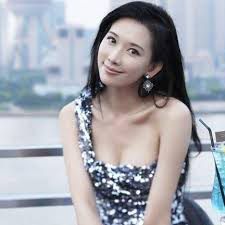

97 19 152 86


["['man', 'woman'][0.09458817 0.9093381 ]"]

In [23]:
### decorator top start
def predict(model, inputs):
    def _predict_one(one_input_arr):
        try:
            image = Image.open(io.BytesIO(one_input_arr))
    ### decorator top end
            
            ### function start
            # image = Image.open(io.BytesIO(open('waue.jpg','rb').read()))
#             image = Image.open(io.BytesIO(open('peggybio.png','rb').read()))

            image = img_to_array(image)
            classes = ['man','woman']
            face, confidence = cvlib.detect_face(image)

            for idx, f in enumerate(face):

                 # get corner points of face rectangle       
                (startX, startY) = f[0], f[1]
                (endX, endY) = f[2], f[3]

                print(startX, startY, endX, endY)
                # draw rectangle over face
                cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)

                # crop the detected face region
                face_crop = np.copy(image[startY:endY,startX:endX])

                # preprocessing for gender detection model
                face_crop = cv2.resize(face_crop, (96,96))
                face_crop = face_crop.astype("float") / 255.0
                face_crop = img_to_array(face_crop)
                face_crop = np.expand_dims(face_crop, axis=0)
                conf = model.predict(face_crop)[0]
                ret_str = str(classes) + str(conf) 
#                 print(ret_str)
            ### function end
            
    ### decorator botton start
            return ret_str
        except Exception as e:
            print(e)
            return []
    
    return [_predict_one(i) for i in inputs]
    ### decorator botton end

# predict(model, [open('star1.jpg','rb').read()]) 
# predict(model, [open('1man2.jpg','rb').read()])    
# predict(model, [open('su3.jpg','rb').read()])    
display(Image.open('dlin4.jpg'))
predict(model, [open('dlin4.jpg','rb').read()])    

# debug

In [ ]:
clipper_conn.cm.get_num_replicas(name=app_name,version=2)

In [ ]:
clipper_conn.get_linked_models(app_name=app_name)

In [ ]:
clipper_conn.link_model_to_app(app_name=app_name, model_name=model_name)

In [ ]:
clipper_conn.get_all_apps()

In [ ]:
clipper_conn.get_clipper_logs()

In [ ]:
!docker ps -a --filter label=ai.clipper.container.label

In [ ]:
!docker ps 

# Clean

clipper_conn.unlink_model_from_app(model_name=model_name, app_name=app_name)



clipper_conn.stop_models(model_name)

clipper_conn.delete_application(app_name)

# Clean-up

clipper_conn.unlink_model_from_app(model_name=model_name, app_name=app_name)

!docker rm -f $(docker ps -a -q) && docker image prune -f